# Design of a pseudo-spectral Poisson solver

# A. Motivation

The evolution of a plasma system is tied to field equations. For the case of electrostatics ($B = 0$), we consider Boltzmann-Gauss/Poisson systems. At this juncture, DECSKS apprehends the Vlasov-Poisson system which requires solution to Poisson's equation (or, Gauss' law) in order to evolve this collisionless plasma system self-consistently, according to either equivalent set of equations:

\begin{eqnarray*}
\frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} + \frac{\partial\phi}{\partial x}\frac{\partial f}{\partial v} = 0, \qquad &  \text{and } & \qquad \frac{\partial^2 \phi}{\partial x^2} = \int_v dv f(t,x,v) - n_0  \\[2em]
& \text{or } & \\[2em]
\frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} - E\frac{\partial f}{\partial v} = 0, \qquad & \text{and } & \qquad \frac{\partial E}{\partial x} = n_0 -  \int_v dv f(t,x,v)
\end{eqnarray*}

For some domains $x\in \mathcal{D}_x, v\in \mathcal{D}_v$. 

For periodic domains (periodic extensions of non-periodic domains), solving Poisson's equation (Gauss' law) can be facilitated by Fourier-based methods, which inherit the superior convergence and accuracy of spectral methods (also, their hangups, e.g. Gibbs oscillations near sharp transition regions).

# B. Goals of this notebook

This notebook focuses on the design of pseudo-spectral (Fourier-based) solutions of the equations on the right-hand side of the above set. Fourier-based methods operate on globally interpolating functions, giving rise to its well-known convergence and accuracy properties. In [1], a Gauss' law Fourier based method is discussed, we repeat equivalent information (the only difference should be that the reference chooses an asymmetric wave number interval).

Solution of the differential equations proceed by electing to differentiate not the function itself (e.g. finite differencing), but instead to differentiate the unique trigonometric interpolation of the function (i.e. the function is projected onto the subspace spanned by complex-valued exponentials in $\mathbb{C}^{n}$, a <i>Fourier transform</i>) so that differentiation is reduced to algebraic multiplication whereafter the obtained derivative can be mapped back onto $\mathbb{R}^n$ (<i>inverse Fourier transform</i>). The efficiency of the transform procedure can be reduced to $O(N_x\log N_x)$ operations for a mesh characterized by $N_x$ grid points, by a divide-and-conquer strategy that recursively groups wave numbers into bins of progressively half the number of wave numbers $N_x$, which constitute the well-known class of algorithms known as the <i>fast Fourier transform (FFT)</i> (e.g. radix-2). Because of the Fourier basis whose basis functions globally interpolate the function, we inherit spectral-like properties and accuracy that is also well-known to be unmatched by any other means.

# C. Setup and definitions

We consider the forms given in section A [1]:

\begin{eqnarray*}
 \frac{\partial E}{\partial x} = n_0 -  \int_v dv f(t,x,v)\qquad &  \text{or } & \qquad \frac{\partial^2 \phi}{\partial x^2} = \int_v dv f(t,x,v) - n_0 
\end{eqnarray*}

where $\partial_x\phi = -E$, and $\phi = \phi (t,x)$ and $E = E(t,x)$.


The ion density is taken to be a cold background (constant) value, chosen so that $n_i \equiv n_0$ maintains quasineutrality globally, i.e. equal to the total number of charge carriers $N_e$ over the length of the domain $L = b - a$ that constitute the electron density $n_e \equiv n$. On scales of the Debye length (note that in the Vlasov model above, $x$ has been normalized by $\lambda_D$ so that it measures multiples of the Debye length) localized electric fields are not sufficiently screened out, as computed by Poisson's equation/Gauss' law. To find the value of the ion background density, we calculate the total number of electrons $N_e$ for the initial distribution:

$$N_e = \int_a^b dx \int_v dv f(t,x,v) = \int_a^b dx \int_v dv f_0(x,v)$$

then, since the number of positive ions, $\int_a^b dx n_0$, must equal this number, and $n_0 = \text{const}$, we have

$$n_0 = \frac{N_e}{b - a}$$

In future work, the ion density can be permitted to evolve alongside the electron distribution by the straightforward inclusion of a Vlasov equation for the ion species distribution function $f_i = f_i(t,x,v)$ and where the ion density $n_i \neq \text{constant}$, but $n_i = \int_v dv f_i(t,x,v)$. In this notebook, we do not address this extension as it is straightforward, <font color = "red">(TODO) but may return to include such details later</font> 

## C.1. Transform definitions

The projection onto the subspace of complex exponentials permits expressing any <i>periodic</i> function as a trigonometric series:

$$f(x) = \sum_{k = -\infty}^{\infty} \mathcal{F}[f](\xi_k) e^{\text{i}\xi_k x}, \quad \xi_k = \frac{2\pi k}{L}$$

<i>(for non-periodic functions, the period $L$ is infinite. Thus, in the limit $L\to\infty$, we have the spacing between each linear frequency $\Delta\nu = \Delta k / L \rightarrow 0$ and arrive at an integral formulation $\xi_k \to 2\pi\nu_k$. That is to say, a continuum of superposed wave frequencies are needed to converge to the original function in the RMSE sense)</i>

Note, the imaginary unit $\text{i} = \sqrt{-1}$ is formatted in plain text to avoid any confusion with the usual grid index associated with the first configurational variable $i$ that is most often used by this author. In the limit above where an infinite number of waves are added (many contributions may be negligible given periodicity), the RMS error between a Fourier series and the function is zero. 

The <i>wave number</i> (or <i>wave frequency</i>) has the form $\xi_k = 2\pi k / L$ for $k\in\mathbb{Z}$, where the name listed parenthetically is common due to Fourier analysis having origins in frequency/time signals, sometimes we call $k/L = \nu_k$, the linear <i>frequency</i>, which is related to a wave <i>period</i> $T_k = 1 / \nu_k = L / k$ for $L = b - a$, where $x\in [a,b]$ for $a,b\in\mathbb{R}$ that are at least large enough to contain one full period. Hence, the coefficient $\mathcal{F}[f](\xi_k)$ can be referred to as the $k$th frequency, or <i>Fourier</i>, component, or even Fourier mode. That is, the set $\{\mathcal{F}[f](\xi_k)\}$ are the aforementioned projections onto the complex exponentials with wave numbers $\{\xi_k\}$, which are obvious when viewing the above series. That is, we multiply by a complex exponential function of the same family and integrate over a period:

\begin{eqnarray*}
\int_{-L/2}^{L/2} dx f(x) e^{-\frac{2\pi\text{i}k}{L}}  & = & \int_{-L/2}^{L/2} dx\sum_{m  =  -\infty}^{\infty} \mathcal{F}[f](m) e^{\frac{2\pi\text{i}m}{L}} e^{-\frac{2\pi\text{i}k}{L}} \\[1em]
\int_{-L/2}^{L/2} dx f(x) e^{-\frac{2\pi\text{i}k}{L}}  & = & \sum_{m  =  -\infty}^{\infty} \mathcal{F}[f](m) \left(\int_{-L/2}^{L/2} dx e^{\frac{2\pi\text{i}(m - k)}{L}}\right) \\[1em]
\int_{-L/2}^{L/2} dx f(x) e^{-\frac{2\pi\text{i}k}{L}}  & = & \sum_{m  =  -\infty}^{\infty} \mathcal{F}[f](m)(L\delta_{mk}) \\[1em]
\int_{-L/2}^{L/2} dx f(x) e^{-\frac{2\pi\text{i}k}{L}}  & = & \mathcal{F}[f](k) L
\end{eqnarray*}

Thus,

$$\mathcal{F}[f](k) = \frac{1}{L}\int_{-L/2}^{L/2} f_L(x) e^{-\frac{2\pi\text{i}}{L}kx}dx = \frac{(f, e^{\frac{2\pi\text{i}}{L}kx})}{(e^{\frac{2\pi\text{i}}{L}kx}, e^{\frac{2\pi\text{i}}{L}kx})} \qquad \underline{\text{Forward (Fourier) transform}}$$

Where the inner product is defined as $(A, B) =  \langle B | A \rangle = \int_{\mathbb{x\in \mathcal{D}}} dx A\bar{B} = \int_{x\in\mathcal{D}} dx B^*A$. The backward transform is easily understood as:

$$\mathcal{F}^{-1}[\mathcal{F}[f_L](k)] = f_L(x) = \int_{-L/2}^{L/2} \mathcal{F}[f_L](k) e^{\frac{2\pi\text{i}}{L}kx}dx = (e^{\frac{2\pi\text{i}}{L}kx},f) \qquad \underline{\text{Backward (inverse Fourier) transform}}$$

On a computer, we write $x_m = m\Delta x = m \frac{L}{N_x}$, $m = 0, 1, \ldots , N_x - 1$. To move from a continuous to a discrete domain is either a long-winded exercise, or follows from waving our hands. We describe the former, <font color = "red">(TODO) which might be shown in another notebook in detail </font>. The rigorous transition involves writing down discrete representations of the continuous function using summations of delta functions $f_{\Delta}(x_m) = f(x)\sum_{m=0}^{N_x - 1}\delta (x - x_m) = \sum_{m=0}^{N_x - 1}f(x_m)\delta (x - x_m)$. We then take its continuous Fourier transform, $\mathcal{F}[f_{\Delta}]$ where the transform of the delta function is computed trivially. Recogizing we have put only one foot in the discrete domain (forming $f_{\Delta}$), but still have the other in the continuum domain (using a continous transform $\mathcal{F}$) we acknowledge more work is needed. Thus, we write an appropriate representation to find $\mathcal{F}[f_{\Delta}]_{\Delta} := \text{DFT}$, the <i>discrete Fourier transform</i> which in tautological terms is the discretized Fourier transform of the discretized function. This again, is done with $\delta$-functions, $\mathcal{F}[f_{\Delta}]_{\Delta}(\nu_k) = \mathcal{F}[f_{\Delta}](\nu )\sum_{k = 0}^{M_{\nu} - 1} \delta (\nu - \nu_k)$, where $\nu_k = k / L$. To remove all traces of the continuum version, we require replacing discrete terms like $x_m$ and $\nu_k$, and to understand the relationship between the number of samples $M_{\nu}$ in frequency space and $N_x$ in real space. By invoking the Shannon interpolation theorem carefully we see the appropriate number is indicated such that $M_{\nu} = N_x$ where the spacing in the $x$ domain is $\Delta x = 1 / L$, and the appearing product $x_m\nu_k$ in the complex exponential of $\mathcal{F}[f_{\Delta}]$ can be written as $mk / N_x$. In this way, we successfully step into a discrete domain while removing all continuum dependencies and can work exclusively with intrinsic and natural labels that characterize the discrete data sets $\{m,k,N_x\}$. 

Alternatively, many authors (defensibly) decide to brazenly skip such a stepthrough and cover tracks by introducing the credible and believable "definitions" of the DFT and IDFT. Which are the same statements as we would produce from the preceding paragraph. That is, we find that the appropriate forms of the DFT and IDFT are given by:

$$\mathcal{F}[f](\xi_k) \simeq \text{DFT}[f](k)  := \frac{1}{N_x} \sum_{m = 0}^{N_x - 1} f(x_m) e^{-\text{i}\xi_k x_m}$$


$$f(x_m) \simeq \text{IDFT}[\text{DFT}[f]](m)  := \sum_{k = 0}^{N_x - 1}\text{DFT}[f](k) e^{\text{i}\xi_k x_m}$$

If a fast Fourier transform (FFT) algorithm is used, then the above transform pair can be written as:

$$\mathcal{F}[f](\xi_k) \simeq \text{FFT}[f](k)  := \frac{1}{N_x} \sum_{m = 0}^{N_x - 1} f(x_m) e^{-\text{i}\xi_k x_m}$$


$$f(x_m) \simeq \text{IFFT}[\text{FFT}[f]](m)  := \sum_{k = 0}^{N_x - 1}\text{FFT}[f](k) e^{\text{i}\xi_k x_m}$$

where we have used the grid points $x_m$ and calculable wave numbers $\xi_k$. In response to the paragraph just before this, it can be seen that $x_m\xi_k = 2\pi m k / N_x$ if desired.


## C.2. Conservation of energy

A Vlasovian plasma conserves any constant of motion, $C = C(f)$, hence the total energy is conserved, $W_E = W_E(f, E(f))$, or $W_E = W_E(f,\phi (f))$:

$$W_E = \int_{x\in\mathcal{D}_x} dx \int_{v\in\mathcal{D}_v}\frac{1}{2}f(x,v)v^2 dv + \int_{x\in\mathcal{D}_x}\frac{1}{2}|E(x)|^2 dx $$

or,

$$W_E = \int_{x\in\mathcal{D}_x} dx \int_{v\in\mathcal{D}_v} \frac{1}{2}f(x,v)v^2 dv+ \int_{x\in\mathcal{D}_x}dx\left(\int_{v\in\mathcal{D}_v} f(x,v) dv - n_0\right)\phi (x)$$

for the case of a constant singly charged ion background density. These statements express the interchanges of energy between particles and the electrostatic field. Hence, the sum of these two energies remain fixed in time; any drop in energy stored by the field is manifest in corresponding rises in particle energy and vice versa. In other words, for a periodic system we partition $\mathbb{R}$ in space as the union of identical cells over smaller domains $\mathcal{D}_x \subset \mathbb{R}$, where the union is completed by periodicity from one cell to the next. Thus, in order to conserve energy for the total space, the electrostatic field cannot have an average non-zero field, else the end points of neighboring cells cannot be matched. This can be enforced directly if $E$ is computed in a Gauss' law solver, or can be equivalently reported as periodic boundary conditions of the electric potential $\phi$.

# D. Gauss' law solver

We solve the discrete problem at each $x_i$ inside the domain $x\in [a, b]$, and enumerate according to $i = 0, 1, 2, \ldots , N_x - 1$.

The right-hand side of Gauss' law is the charge density $\rho (x)$ which for our model case of a constant singly charged ion background density $n_0$ and an evolving distribution function for electrons can be computed as $\rho (x) = n_0 -  \int_v dv f(t,x,v)$, or discretely as $\rho_i = n_0 - \sum_j \Delta v_j f_{i,j}^n$ for $f_{i,j}^n \equiv f(t^n, x_i, v_j)$, and $\rho_i \equiv \rho (x_i)$, then the governing equation is:

$$\left(\frac{\partial E}{\partial x}\right)_{x = x_i} = \rho_i$$

For the Fourier algorithm, we develop the continuum version (transforms $\mathcal{F}$ and $\mathcal{F}^{-1}$), then assert the discrete case ($\text{FFT}/\text{IFFT}$) holds:

\begin{eqnarray*}
\frac{\partial E}{\partial x} & = & \rho \\
\end{eqnarray*}

For reasons that will be clear soon enough, we partition the electric field $E$ as

$$E(t,x) = \langle E \rangle + \tilde{E}(t,x)$$

where $\langle E \rangle \equiv \langle E \rangle_x$ is averaged over the configuration variable $x$. In particular, it will be seen that the transformed Gauss' law precludes computing all the components involved in the transformed field $\mathcal{F}E$ directly since the $k = 0$ Fourier mode equation is not useful ($0 = 0$) and does not provide a means to calculate $\mathcal{F}E(0)$ (and hence the DC component $\mathcal{F}^{-1}\mathcal{F}E(0) \equiv \langle E \rangle$ is not obtainable). Notwithstanding, we understand that while the DC field component ($k = 0$) in inaccessible directly, the following formulation does give all the information of every other harmonic ($k \neq 0$) which describes <i>fluctuations</i> from the mean value $\langle E \rangle$. Thus, it is seen that the scheme allows for computation of fluctuating field $\tilde{E}(t,x) = E(t,x) - \langle E \rangle$(i.e. $\langle \tilde{E} \rangle = 0$, thus its Fourier DC component, $\mathcal{F}\tilde{E}(k=0) = 0$). If we can find or know the mean field $\langle E \rangle$ (e.g. if $\langle E \rangle$ is a constant external field applied) then the above partition allows calculation of the total field $E$. Hence, we separate the contributions to the total field $E$ as above.

For our purposes, the plasma conserves energy so worrying about the mean field is not a concern ($\langle E \rangle = 0$ is required for energy conservation). Thus, for this special case, $E(t,x) = \tilde{E}(t,x)$ and the algorithm described provides us with the exact field required in the intended context (Vlasov-Poisson plasma kinetic solver). Note, for generality, we keep the diacritic $\sim$ on symbols to indicate that it is the fluctuating parts we are solving for, and that while our restricted applications have the fortune that this happens to correspond to the total field, it is not the case for all readers. 

Thus, instead of the above equation, we consider solving the fluctuating field by means of Fourier methods:

\begin{eqnarray*}
\frac{\partial \tilde{E}}{\partial x} & = & \tilde{\rho} \\
\end{eqnarray*}

where $\tilde{\rho} = \rho - \langle \rho \rangle_x$, and $\tilde{E} = E - \langle E \rangle_x$. 

Apply the continuous forward transform:

\begin{eqnarray*}
\mathcal{F}\left[\frac{\partial \tilde{E}}{\partial x}\right](k) & = & \mathcal{F}[\tilde{\rho}](k) \\
\frac{1}{L}\int_{-L/2}^{L/2}\frac{\partial \tilde{E}}{\partial x} e^{-\frac{\text{i}\xi_k}{L}x}dx & = & \mathcal{F}\tilde{\rho} \\
\underbrace{\frac{1}{L}\left(\tilde{E}e^{-\text{i}\xi_k x}\right)_{-L/2}^{L/2}}_{=\, 0,\, \text{periodicity}} - (-\text{i}\xi_k) \underbrace{\frac{1}{L}\int_{-L/2}^{L/2}\tilde{E} e^{-\text{i}\xi_k x}dx}_{= \mathcal{F}[\tilde{E}](k)} & = & \mathcal{F}\tilde{\rho} \\
\text{i}\xi_k \mathcal{F}[\tilde{E}](k) & = & \mathcal{F}[\tilde{\rho} ] (k), \qquad \text{for all } \xi_k = \frac{2\pi k}{L}, \, k = \{0, 1, \ldots , N_x - 1 \}
\end{eqnarray*}

The $k = 0$ term does not provide an equation that involves $\mathcal{F}\tilde{E}(0)$ (i.e. the equation for $k = 0$ pertains to $\xi_k = 2\pi (0) / L = 0$, so the above equation is $0 = \mathcal{F}[\tilde{\rho} ] (0)$, which only gives information about the DC component of the fluctuating density, which was already known to be zero beforehand since by definition the mean of a fluctuating quantity is zero. On that same note, we can consider how to discern the value of $\mathcal{F}\tilde{E}(0)$ by the same thought process: the fluctuating field $\tilde{E}$ which has a mean $\langle \tilde{E} \rangle = 0$, thus $\mathcal{F}\tilde{E}(0) = 0$ as well. So, we also already know its value just the same for the above setup. This brings to light the motivation for why we are seeking the fluctuating field in the Fourier transform solution, it is exactly because the $k = 0$ equation would not provide any useful information about $\mathcal{F}E(0)$. The workaround for this problem is as was done above, we consider solving for a quantity whose zeroeth Fourier mode we know, once it is agreed on which quantity to seek then the total field can be assembled by superposition. It is most natural to choose to find the fluctuating field $\tilde{E}$ with zero mean, as we have done above. Concretely, we write

$$\mathcal{F}[\tilde{E}](k) = \begin{cases}
0, & k = 0 \\
& \\
\frac{1}{\mathrm{i}\xi_k}\mathcal{F}[\tilde{\rho}](k), & k = 1, 2, \ldots , N_x - 1, \, \xi_k = \frac{2\pi k}{L}\end{cases}$$

so, that the electric field can be computed from Gauss' law swiftly by an inverse of the above quantity:

$$\tilde{E}(t,x) =  \mathcal{F}^{-1}\left[\mathcal{F}[\tilde{E}] \right]$$

For the discrete case (using FFT/IFFT), we set up a grid function vectors for the field $\underline{\tilde{E}} = \underline{\tilde{E}}(\underline{x})$, total charge density $\underline{\tilde{\rho}} = \underline{\tilde{\rho}}(\underline{x})$ at each $\underline{x} = \{x_i\}$, for $i = 0, 1, \ldots , N_x - 1$, $x_i\in [a, b]$. We also assemble the discrete Fourier transform vectors $\text{FFT}[\underline{\tilde{\rho}}] = \text{FFT}[\underline{\tilde{\rho}}][\underline{k}]$, and $\text{FFT}[\underline{\tilde{E}}] = \text{FFT}[\underline{\tilde{E}}][\underline{k}]$, whose entries correspond to each Fourier component $k = 0, 1, 2, \ldots N_x - 1$. Thus, the discrete computation of the above is translated as:

$$\boxed{\underline{\tilde{E}}(t^n,\underline{x}) = \text{IFFT}[\text{FFT}[\underline{\tilde{E}}] ]} \qquad \qquad (1)$$

where 

$$\text{FFT}[\underline{\tilde{E}}] = \left\{ \left[0, \left(\frac{\text{FFT}[\tilde{\rho} ](k)}{\text{i}\xi_k}\right)_{k = 1}^{N_x - 1}\right]\right\} \qquad \qquad (2)$$

and, the meaning of the inner object above is the scaled transform vector including the zero average field entry at $k = 0$:

$$\left[0, \left(\frac{\text{FFT}[\tilde{\rho}]_k}{\text{i}\xi_k}\right)_{k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\tilde{\rho}](1)}{\text{i}\xi_0}, \frac{\text{FFT}[\tilde{\rho}](2)}{\text{i}\xi_1}, \frac{\text{FFT}[\tilde{\rho}](3)}{\text{i}\xi_2} , \ldots , \frac{\text{FFT}[\tilde{\rho}](N_x-1)}{\text{i}\xi_{N_x -1}} \right), \qquad (3)$$


<b>for the case of a quasineutral plasma that conserves energy:</b>, $\langle E \rangle = 0$ so $\boxed{\underline{E}(t^n,\underline{x}) = \underline{\tilde{E}}(t^n, \underline{x})}$ is given directly by eq. (1).


<b>Caution</b>: in the Fourier calculation of integration, we have shown the following mapping: $\int \mapsto 1 / (\text{i}\xi_k)$ holds. It is emphasized that the $k$th wave number in $1 / (\text{i}\xi_k)$ must be multiplied by the $k$th component of $\text{FFT}[\rho](k)$. That is, the wave numbers will need to be computed (see section D) and multiplied by the element of the Fourier transform vector $\text{FFT}[\rho](\ell )$ that actually pertains to the $k$th frequency component. It should <i>not</i> be assumed that the $\ell$th component of $\text{FFT}[\underline{\rho}]$ is the $k$th freqency component...it depends on how the transform vector is organized! Different programming languages are equipped with modules that may use different ordering of the Fourier transformed vector, thus it is necessary to learn what organization is used so that the multiplication as in the above does pertain to integration and is not a random product that does not have any meaning (i.e. it is meainingless to compute $\text{FFT}[\rho ](\ell ) / (\text{i}\xi_k)$ for $k \neq \ell$). Some languages find it most convenient to put the DC component ($k = 0$) in the center of the actual transform vector, and naturally putting negative frequencies at lower indices (to the left of the center), and positive frequencies to the right (higher indices). Thus, if you are using someone else's FFT routine (as we are, numpy.fft), then it is necessary to find out what kind of result is provided from the function call.  

In the Python numpy.fft module [2]:

"<i>The values in the result follow so-called “standard” order: If A = fft(a, n), then A[0] contains the zero-frequency term (the mean of the signal), which is always purely real for real inputs. Then A[1:n/2] contains the positive-frequency terms, and A[n/2+1:] contains the negative-frequency terms, in order of decreasingly negative frequency. For an even number of input points, A[n/2] represents both positive and negative Nyquist frequency, and is also purely real for real input. For an odd number of input points, A[(n-1)/2] contains the largest positive frequency, while A[(n+1)/2] contains the largest negative frequency</i>"

Thus, in section D, below, we compute a wave number vector $\underline{\xi} = \{\xi_k\}$ for each $k$, where for $k = 1$ to $k = N_x / 2$ we compute $\xi_k = 2\pi k / N_x$, and after the Nyquist frequency at the index $k = N_x / 2$, we compute (as described above in the paste from the numpy.fft documentation) the negative frequency contributions $\xi_k = 2\pi (k - N_x)/ L$ organized in order of decreasingly negative frequency. This sets up the vector $\underline{\xi}$ in the same ordering as transform vectors, say $\text{FFT}[\underline{\rho}]$. Thus, this setup makes the $\ell$th entry in $\text{FFT}[\underline{\rho}]$ agree with the $k$th wave numbers, i.e. $\ell = k$. This nuance is something that needs to be addressed as it perhaps is the most common way to implement Fourier differentiation/integration incorrectly.

## D.1. General algorithm

Here, we assume the charge density $\rho$ is calculable or otherwise known, and that an external constant electric field is applied so that $\langle E \rangle$ is known.

<ol>
<li> Compute the wave number vector $\underline{\xi}$, where the $k$th wave number is given by:
$${}$$
$$ \xi_k =
  \begin{cases}
   2\pi k / L & \text{if } k \leq N_x/2 \\[0.5em]
   2\pi (k - N_x) / L       & \text{else}
  \end{cases}$$
$${}$$
Note, this computation recognizes that second half of the wave numbers are equal to the negative wave numbers.

<li> Calculate the fluctuating charge density directly:
$${}$$
$$\tilde{\rho} = \rho - \langle \rho \rangle, \qquad \langle \rho \rangle = \frac{\sum_{i\in\mathbb{N}_x} \rho_i \Delta x_i}{\sum_{i\in\mathbb{N}_x} \Delta x_i}$$
$${}$$
and compute its discrete Fourier transform, e.g. by a fast Fourier transform algorithm,
$${}$$
$$\text{FFT}[\underline{\tilde{\rho}}] = (\text{FFT}[\tilde{\rho}](0), \text{FFT}[\tilde{\rho}](1), \text{FFT}[\tilde{\rho}](2), \ldots , \text{FFT}[\tilde{\rho}](N_x - 1)) = \left(\text{FFT}[\tilde{\rho}](\ell )\right)_{\ell = 0}^{N_x - 1}$$
$${}$$

Note, the $\ell = 0$ component will be computed as zero given the construction. Equivalently, we can forego the above and just compute the FFT of $\rho$ where we zero out the DC component $\text{FFT}[{\rho}](0) = 0$.

<li> Find the discrete Fourier transform of the fluctuating field component, $\text{FFT}[\tilde{E}]$, from eqs. (2), (3):
$${}$$
$$\text{FFT}[\tilde{E}] = \left[0, \left(\frac{\text{FFT}[\tilde{\rho}](\ell )}{\text{i}\xi_k}\right)_{\ell = k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\tilde{\rho}](1)}{\text{i}\xi_0}, \frac{\text{FFT}[\tilde{\rho}](1)}{\text{i}\xi_1}, \frac{\text{FFT}[\tilde{\rho}](2)}{\text{i}\xi_2} , \ldots , \frac{\text{FFT}[\tilde{\rho}](N_x-1)}{\text{i}\xi_{N_x -1}} \right)$$
$${}$$
where the $\ell$th component of $\text{FFT}[\underline{\tilde{\rho}}]$ must correspond to the $k$th Fourier wave number. If using a library module to compute an FFT, this may require reviewing the associated documentation to understand the organization of returned FFT vectors, so it is understood which vector entry corresponds to which wave number, e.g. in numpy.fft we consult [2] (the wave number vector computed in step (1) is in the same order as the vector returned by numpy.fft.fft)

Note, in NumPy arrays, a vectorized computation of this does not require looping and can be done by numpy division of two arrays.


<li> Find the fluctuating electric field in real space by taking the IFFT of the vector computed in step (3):  per eq. (1)
$${}$$
$$\underline{\tilde{E}}(t^n,\underline{x}) = \text{IFFT}[\text{FFT}[\tilde{E}]] \qquad \qquad (1, \text{revisited})$$
$${}$$


<li> The total field is then $\underline{E}(t^n, \underline{x}) = \langle \underline{E}(t^n, \underline{x})\rangle + \underline{\tilde{E}}(t^n,\underline{x})$

</ol>


## D.2. Algorithm for Vlasov-Poisson plasmas with cold ion background density

Here, we assume the charge density $\rho$ needs to be calculated at each time $t^n$ in a simulation as the difference between a constant background (singly charged) ion density $n_0$ and the evolving distribution function for electrons $f = f(t^n, x_i, v_j)$.

<ol>
<li> Compute the wave number vector $\underline{\xi}$, where the $k$th wave number is given by:
$${}$$
$$ \xi_k =
  \begin{cases}
   2\pi k / L & \text{if } k \leq N_x/2 \\[0.5em]
   2\pi (k - N_x) / L       & \text{else}
  \end{cases}$$
$${}$$
Note, this computation recognizes that second half of the wave numbers are equal to the negative wave numbers.

<li> Calculate the fluctuating charge density $\tilde{\rho}$. Since a plasma is quasineutral, this is equivalent to computing the total charge density given that the average electron density is equal to the constant ion background $n_0$, i.e. $\tilde{\rho} = n_0 - \int_v dv f(t,x,v)$ since any localized charge separation is exclusively due to electron fluctuations (the $n_0$ term from the ion density cancels with the DC offset of the term $\int_v dv f(t,x,v)$ leaving only th residual fluctuations). For singly charged ions in our normalized units (charges = $\pm 1$), we have the discrete computation:

$${}$$
$$\tilde{\rho}_i = n_0 - \sum_{j = 0}^{N_v - 1} \Delta v f^n_{i,j}$$
$${}$$

where $\tilde{\rho}_i \equiv \tilde{\rho}(x_i)$ and compute the discrete Fourier transform of its vector object $\underline{\tilde{\rho}}$, e.g. by a fast Fourier transform algorithm,
$${}$$
$$\text{FFT}[\underline{\tilde{\rho}}] = (\text{FFT}[\tilde{\rho}](0), \text{FFT}[\tilde{\rho}](1), \text{FFT}[\tilde{\rho}](2), \ldots , \text{FFT}[\tilde{\rho}](N_x - 1)) = \left(\text{FFT}[\tilde{\rho}]\right)_{\ell = 0}^{N_x - 1}$$
$${}$$
<li> Find the discrete Fourier transform of the fluctuating field component, $\text{FFT}[\tilde{E}]$, from eqs. (2), (3):
$${}$$
$$\text{FFT}[\tilde{E}] = \left[0, \left(\frac{\text{FFT}[\tilde{\rho}](\ell )}{\text{i}\xi_k}\right)_{\ell = k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\tilde{\rho}](1)}{\text{i}\xi_0}, \frac{\text{FFT}[\tilde{\rho}](2)}{\text{i}\xi_1}, \frac{\text{FFT}[\tilde{\rho}](3)}{\text{i}\xi_2} , \ldots , \frac{\text{FFT}[\tilde{\rho}](N_x-1)}{\text{i}\xi_{N_x -1}} \right)$$
$${}$$
where the $\ell$th component of $\text{FFT}[\underline{\tilde{\rho}}]$ must correspond to the $k$th Fourier wave number. If using a library module to compute an FFT, this may require reviewing the associated documentation to understand the organization of returned FFT vectors, so it is understood which vector entry corresponds to which wave number, e.g. in numpy.fft we consult [2] (the wave number vector computed in step (1) is in the same order as the vector returned by numpy.fft.fft)

Note, in NumPy arrays, a vectorized computation of this does not require looping and can be done by numpy division of two arrays.


<li> Find the fluctuating electric field in real space by taking the IFFT of the vector computed in step (3):  per eq. (1)
$${}$$
$$\underline{\tilde{E}}(t^n,\underline{x}) = \text{IFFT}[\text{FFT}[\tilde{E}]] \qquad \qquad (1, \text{revisited})$$
$${}$$


<li> Since such a plasma conserves energy, $\langle E \rangle = 0$, thus the total field is $\underline{E}(t^n, \underline{x}) = \underline{\tilde{E}}(t^n,\underline{x})$ as computed in the previous step.

</ol>


## D.3. Implementation and test case: periodic

We consider the solution to Gauss' law:

$$\partial_x E = \rho, \quad x\in [0, 1]$$

We choose a 1-periodic solution:

$$\phi (x) = \sin (2\pi x)$$

this implies $E(x) = -\partial_x\phi (x)$, or

$$E = -2\pi\cos(2\pi x)$$

and by Gauss' law, $\rho = \partial_x E = 4\pi^2\sin (2\pi x)$, thus we assess if the method can reproduce the solution $E$ given the equation:

$$\text{Test problem: } \qquad \frac{\partial E}{\partial x} = 4\pi^2\sin (2\pi x),\quad x\in [0, 1]$$

Since the electric field and charge density both have zero mean, we have $\tilde{E} = E$ and $\tilde{\rho} = \rho$, the above algorithm can be used to compute the total field $E$.


In [317]:
%reload_ext autoreload 
%autoreload 2 
import numpy as np

def Gauss(rho, x):
    """Computes self-consistent electric field E by solving Gauss' law
    using FFT/IFFT.

    inputs:
    rho -- (ndarray, ndim = 1)  charge density vector,
    f -- (ndarray, dim=2) electron density fe(x,v,n) at time step t^n
                          used to compute ne(x,n) at time step t^n
    x -- (ndarrya, ndim = 1) configurational variable

    outputs:
    E -- (ndarray,dim=1) electric field, E(x) at time t^n
    """
    Nx = len(x)
    L = np.max(x) - np.min(x)
    dx = L / (Nx - 1)
    
    # create wave number vector in same order as return of numpy.fft.fft
    xi = np.zeros(Nx)
    xi[0:Nx/2 + 1] = 2 * np.pi * np.arange(Nx/2 + 1) / L
    xi[Nx/2 + 1:] = 2 * np.pi * (np.arange(Nx/2 + 1, Nx) - Nx) / L

    # Fluctuating electric field in Fourier space, FE_tilde[0] = 0 already
    FE_tilde = np.zeros(Nx, dtype = complex)
    Frho_tilde = np.fft.fft(rho)
    FE_tilde[1:Nx] = Frho_tilde[1:Nx] / (1j * xi[1:Nx])
    
    # Electric field in configurational space
    E_tilde = np.real(np.fft.ifft(FE_tilde))
    return E_tilde

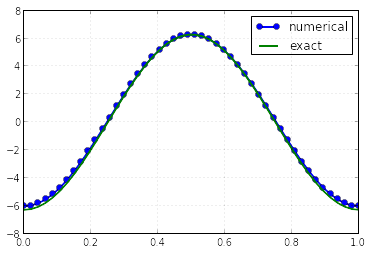

In [318]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# grid setup
Nx = 48
a, b = 0., 1.
x = np.linspace(a,b,Nx)

rho = 4*np.pi**2 * np.sin(2*np.pi * x) 
E = Gauss(rho,x)
E_exact = -2*np.pi*np.cos(2*np.pi*x)

plt.plot(x,E, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,E_exact, linewidth = 2, label = 'exact')
plt.hold('off')
plt.legend(loc = 'best')
plt.grid('on')

## D.4. Implementation and test case: non-periodic waveform $\rho$ with $\langle\rho\rangle = 0,\, \langle E \rangle \neq 0$

We choose the same form of the $\phi$ solution as in section D.3., but restrict its extent so that:

$$\phi (x) = \begin{cases} 
\sin (2\pi x) & 1/4 \leq x \leq 3/4 \\
0 & \text{else}
\end{cases}$$

is a non-periodic function. Then, since $E(x) = -\partial_x\phi (x)$, we have the exact electric field given by

$$E (x) = \begin{cases} 
-2\pi\cos(2\pi x) & 1/4 \leq x \leq 3/4 \\
0 & \text{else}
\end{cases}\qquad \qquad \langle E \rangle = 2$$


and by Gauss' law, $\rho = \partial_x E$, thus we have

$$\rho (x) = \begin{cases} 
4\pi^2\sin (2\pi x) & 1/4 \leq x \leq 3/4 \\
0 & \text{else}
\end{cases} \qquad \qquad \langle \rho\rangle = 0$$

thus we assess if the method can reproduce the solution $E$ given the equation:

$$\text{Test problem: } \qquad \frac{\partial E}{\partial x} = \rho (x) ,\quad x\in [0, 1]$$

The charge density has the following form over the domain. The waveform is <i>not</i> periodic, but it is clear a periodic extension can be defined on a function $\rho_{\ell}$ such that $\rho_{\ell}(x + 1) = \rho (x)$. Thus, in our Gauss' law solver, we actually solve for $\rho_{\ell}\in [0,1] \equiv \rho$. Since this necessary step does not affect any calculations in the stepthrough, swapping labels with $\rho$ and $\rho_{\ell}$ is not fussed with to avoid unnecessary confusion. The periodic extension in such cases should be tacitly understood.

Below, we plot the charge density and electric field:

### D.4.1. Grid and exact solution setup

In [319]:
import numpy as np

# grid setup
Nx = 512
a, b = 0., 1.
x = np.linspace(a,b,Nx)
L = b - a
dx = L / (Nx - 1)

# all quantities only nonzero inside x_L <= x <= x_R
x_L, x_R = 0.25, 0.75

# extract arrays of indices for x_L <= x  <= x_R
interior_ind = np.where((x >= x_L) & (x <= x_R))
exterior_ind = np.where((x < x_L) | (x > x_R))

# charge density
rho = np.zeros(Nx)
rho[exterior_ind] = 0
rho[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*x[interior_ind])
rho_avg = np.sum(rho)*dx / L

# the exact electric field is only non-zero in the range x_L <= x <= x_R
E_exact = np.zeros(Nx)
E_exact[interior_ind] = -2*np.pi * np.cos(2*np.pi * x[interior_ind])
E_exact[exterior_ind] = 0
E_avg = np.sum(E_exact)*dx / (b - a)

### D.4.2. Plots of exact charge density and electric field

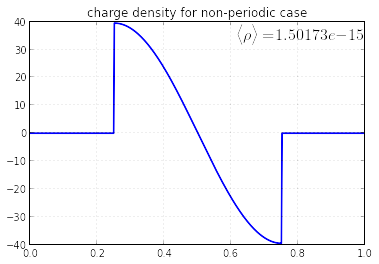

In [320]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x,rho, linewidth = 2)
plt.title('charge density for non-periodic case')
plt.text(1.0, 40, r'$\langle\rho\rangle = %g$' % rho_avg, horizontalalignment = 'right', verticalalignment = 'top', fontsize = 16)
plt.grid('on')

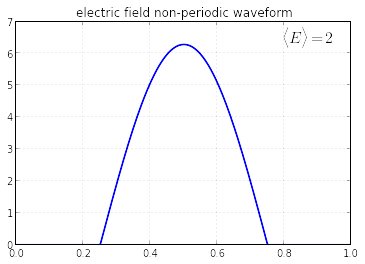

In [321]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x,E_exact, linewidth = 2)
plt.title('electric field non-periodic waveform')
plt.text(.95, 6.9, r'$\langle E \rangle = %g$' % E_avg, horizontalalignment = 'right', verticalalignment = 'top', fontsize = 16)
plt.grid('on')

### D.4.3. Numerical solution calculation and plots

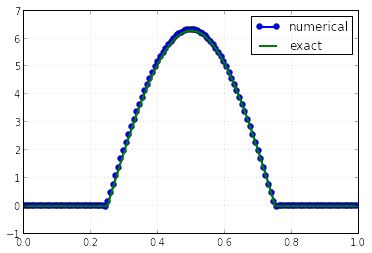

In [322]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# grid setup
NX = 128
dX = (b - a) / (NX - 1)
X = np.linspace(a,b,NX)

# density only inside an interior: 0.25 = x_L <= x <= 0.75 = x_R
interior_ind = np.where((X >= x_L) & (X <= x_R))
exterior_ind = np.where((X < x_L) | (X > x_R))


# charge density is only non-zero in range x_L <= X <= x_R
rho = np.zeros(NX)
rho[exterior_ind] = 0
rho[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*X[interior_ind])

E_tilde = Gauss(rho,X)

E_total = E_tilde + E_avg
plt.plot(X,E_total, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,E_exact, linewidth = 2, label = 'exact')

plt.hold('off')
plt.legend(loc = 'best')
plt.grid('on')

## D. 4.5. Implementation and test case: non-periodic density $\rho$ with DC offset, $\langle E \rangle \neq 0$

We choose a similar solution as in section D.3, but append a quadratic term and limit its extent in the domain:

$$\phi (x) = \begin{cases} 
\sin (2\pi x) + 2x & 1/4 \leq x \leq 3/4 \\
0 & \text{else}
\end{cases}$$

then, since $E(x) = -\partial_x\phi (x)$, we have the exact electric field given by

$$E (x) = \begin{cases} 
-2\pi\cos(2\pi x) - 2 & 1/4 \leq x \leq 3/4 \\
0 & \text{else}
\end{cases}$$

and by Gauss' law, $\rho = \partial_x E$, thus we have

$$\rho (x) = \begin{cases} 
4\pi^2\sin (2\pi x) & 1/4 \leq x \leq 3/4 \\
0 & \text{else}
\end{cases}$$

thus we assess if the method can reproduce the solution $E$ given the equation:

$$\text{Test problem: } \qquad \frac{\partial E}{\partial x} = \rho (x) ,\quad x\in [0, 1]$$

The charge density has the following form over the domain. The function is <i>not</i> periodic, but it is clear a periodic extension can be defined on a function $\rho_{\ell}$ such that $\rho_{\ell}(x + 1) = \rho (x)$. Thus, in our Gauss' law solver, we actually solve for $\rho_{\ell}\in [0,1] \equiv \rho$. Since this necessary step does not affect any calculations in the stepthrough, swapping labels with $\rho$ and $\rho_{\ell}$ is not fussed with to avoid unnecessary confusion. The periodic extension in such cases should be tacitly understood.

### D.4.5.1. Grid and exact solution setup

In [323]:
import numpy as np

# grid setup
Nx = 512
a, b = 0., 1.
x = np.linspace(a,b,Nx)
L = b - a
dx = L / (Nx - 1)

# all quantities only nonzero inside x_L <= x <= x_R
x_L, x_R = 0.25, 0.75

# extract arrays of indices for x_L <= x  <= x_R
interior_ind = np.where((x >= x_L) & (x <= x_R))
exterior_ind = np.where((x < x_L) | (x > x_R))

# charge density
rho = np.zeros(Nx)
rho[exterior_ind] = 0
rho[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*x[interior_ind])
rho_avg = np.sum(rho)*dx / L

# the exact electric field is only non-zero in the range x_L <= x <= x_R
E_exact = np.zeros(Nx)
E_exact[interior_ind] = -2*np.pi * np.cos(2*np.pi * x[interior_ind]) - 2
E_exact[exterior_ind] = 0
E_avg = np.sum(E_exact)*dx / (b - a)

### D.4.5.1. Plots of exact charge density and electric field

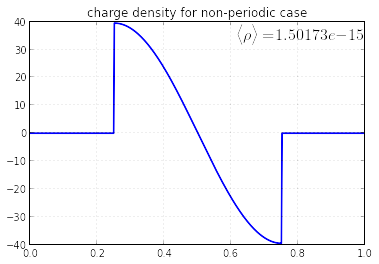

In [324]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x,rho, linewidth = 2)
plt.title('charge density for non-periodic case')
plt.text(1.0, 40, r'$\langle\rho\rangle = %g$' % rho_avg, horizontalalignment = 'right', verticalalignment = 'top', fontsize = 16)
plt.grid('on')

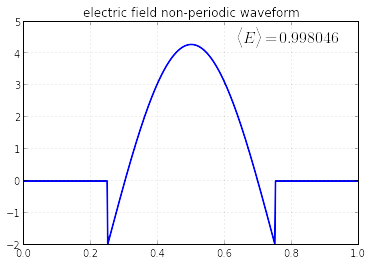

In [325]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x,E_exact, linewidth = 2)
plt.title('electric field non-periodic waveform')
plt.text(.95, 4.90, r'$\langle E \rangle = %g$' % E_avg, horizontalalignment = 'right', verticalalignment = 'top', fontsize = 16)
plt.grid('on')

### D.4.5.3. Numerical solution calculation and plots

[-2.00705793 -2.00713327 -2.00698222 -2.00720971 -2.00690466 -2.0072888
 -2.00682361 -2.0073723  -2.00673712 -2.00746238 -2.00664277 -2.00756181
 -2.00653731 -2.0076744  -2.00641622 -2.00780564 -2.00627279 -2.00796385
 -2.0060965  -2.0081625  -2.00586979 -2.00842502 -2.00556068 -2.00879626
 -2.00510412 -2.00937435 -2.00434463 -2.0104217  -2.00280047 -2.01293439
 -1.99799507 -2.02557705 -1.87135614 -1.53559851 -1.24329731 -0.92762053
 -0.63213982 -0.32614591 -0.03517629  0.26045034  0.54275946  0.82594065
  1.09628168  1.36463308  1.6200772   1.87118971  2.1090693   2.34062087
  2.55849971  2.76831496  2.9639868   3.15007609  3.32157344  3.48216171
  3.62776804  3.76131756  3.87957998  3.9848086   4.07454954  4.15044521
  4.21077235  4.25660428  4.28691835  4.3022449   4.3022449   4.28691835
  4.25660428  4.21077235  4.15044521  4.07454954  3.9848086   3.87957998
  3.76131756  3.62776804  3.48216171  3.32157344  3.15007609  2.9639868
  2.76831496  2.55849971  2.34062087  2.1090693   1.8

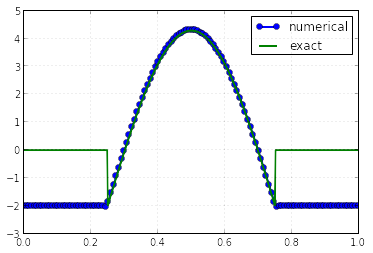

In [327]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# grid setup
NX = 128
dX = (b - a) / (NX - 1)
X = np.linspace(a,b,NX)

# density only inside an interior: 0.25 = x_L <= x <= 0.75 = x_R
interior_ind = np.where((X >= x_L) & (X <= x_R))
exterior_ind = np.where((X < x_L) | (X > x_R))


# charge density is only non-zero in range x_L <= X <= x_R
rho = np.zeros(NX)
rho[exterior_ind] = 0
rho[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*X[interior_ind])

E_tilde = Gauss(rho,X)

E_total = E_tilde
print E_tilde
print "E_avg is..."
print E_avg
plt.plot(X,E_total, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
print len(x)
print len(E_exact)
plt.plot(x,E_exact, linewidth = 2, label = 'exact')

plt.hold('off')
plt.legend(loc = 'best')
plt.grid('on')

## D.5. Implementation and test case: non-periodic density $\rho$ with $\langle\rho\rangle \neq 0, \, \langle E \rangle \neq 0$

We choose a similar solution as in section D.3, but append a quadratic term and limit its extent in the domain:

$$\phi (x) = \begin{cases} 
\sin (2\pi x) + x^2 & 1/4 \leq x \leq 3/4 \\
0 & \text{else}
\end{cases}$$

then, since $E(x) = -\partial_x\phi (x)$, we have the exact electric field given by

$$E (x) = \begin{cases} 
-2\pi\cos(2\pi x) - 2x & 1/4 \leq x \leq 3/4 \\
0 & \text{else}
\end{cases}$$

and by Gauss' law, $\rho = \partial_x E$, thus we have

$$\rho (x) = \begin{cases} 
4\pi^2\sin (2\pi x) - 2 & 1/4 \leq x \leq 3/4 \\
0 & \text{else}
\end{cases}$$

thus we assess if the method can reproduce the solution $E$ given the equation:

$$\text{Test problem: } \qquad \frac{\partial E}{\partial x} = \rho (x) ,\quad x\in [0, 1]$$

The charge density has the following form over the domain. The function is <i>not</i> periodic, but it is clear a periodic extension can be defined on a function $\rho_{\ell}$ such that $\rho_{\ell}(x + 1) = \rho (x)$. Thus, in our Gauss' law solver, we actually solve for $\rho_{\ell}\in [0,1] \equiv \rho$. Since this necessary step does not affect any calculations in the stepthrough, swapping labels with $\rho$ and $\rho_{\ell}$ is not fussed with to avoid unnecessary confusion. The periodic extension in such cases should be tacitly understood.

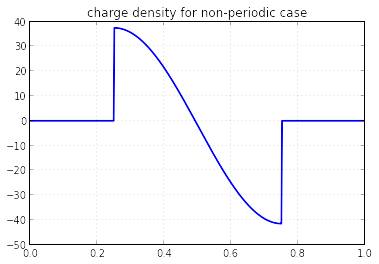

In [251]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# grid setup
Nx = 512
a, b = 0., 1.
x = np.linspace(a,b,Nx)

# density only inside an interior: 0.25 <= x <= 0.75
interior_ind = np.where((x >= 0.25) & (x <= 0.75))
exterior_ind = np.where((x < 0.25) | (x > 0.75))

rho = np.zeros(Nx)
rho[exterior_ind] = 0
rho[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*x[interior_ind]) - 2

plt.plot(x,rho, linewidth = 2)
plt.title('charge density for non-periodic case')
plt.grid('on')

Note, that from the plot above and the functional form, it is clear that $\langle \rho \rangle \neq 0$. Similarly, electric field mean $\langle E \rangle \neq 0$, thus the algorithm above solves for the fluctuating field $\tilde{E}$ and we must piece together the total field $E = \tilde{E} + \langle E \rangle$ by other means. In this case, we have a priori knowledge of the field given the functional form, so we can compute its value and superpose it on top of the fluctuating component to obtain this total field.

[-2.00740417 -1.9874481  -1.96426839 -1.94734664 -1.92086901 -1.90768189
 -1.87677154 -1.86915135 -1.83072819 -1.8343026  -1.77644134 -1.82511243
 -1.41371664 -0.54743007  0.19421279  0.9647079   1.64702057  2.30104445
  2.86090711  3.35706135  3.74941665  4.05333676  4.24728816  4.33687419
  4.31659252  4.18422704  3.94975095  3.60297062  3.17022125  2.63101237
  2.03103819  1.33354534  0.61175137 -0.20324175 -0.98245369 -1.89788854
 -2.30928434 -2.21146496 -2.23175713 -2.18368472 -2.18262658 -2.1467778
 -2.13757664 -2.10770911 -2.09379267 -2.0678542  -2.05050923 -2.02768583]


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide


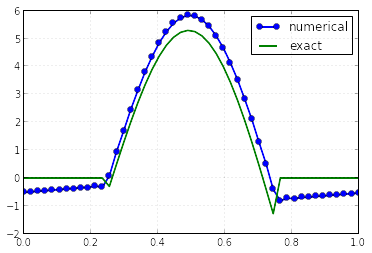

In [252]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# grid setup
Nx = 48
a, b = 0., 1.
dx = (b - a) / (Nx - 1)
x = np.linspace(a,b,Nx)

# density only inside an interior: 0.25 = x_L <= x <= 0.75 = x_R
x_L, x_R = 0.25, 0.75
interior_ind = np.where((x >= x_L) & (x <= x_R))
exterior_ind = np.where((x < x_L) | (x > x_R))


# charge density is only non-zero in range x_L <= x <= x_R
rho = np.zeros(Nx)
rho[exterior_ind] = 0
rho[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*x[interior_ind]) - 2

E_tilde = Gauss(rho,x)
# the exact electric field is only non-zero in the range x_L <= x <= x_R
E_exact = np.zeros(Nx)
E_exact[interior_ind] = -2*(np.pi * np.cos(2*np.pi * x[interior_ind]) + x[interior_ind])
E_exact[exterior_ind] = 0
E_avg = np.sum(E_exact)*dx / (b - a)

E_total = E_tilde + E_avg
print E_tilde
plt.plot(x,E_total, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,E_exact, linewidth = 2, label = 'exact')
plt.hold('off')
plt.legend(loc = 'best')
plt.grid('on')

# E. Poisson's equation solver

We consider the equation:

$$\frac{\partial^2 \phi}{\partial x^2} = \rho$$

Where the right-hand side is casted as a charge density $\rho$ as in section D. From eq. (1), we note that $E = -\partial_x \phi$ indicates

$$\underline{\partial_x\tilde{\phi}}(t^n,\underline{x}) = \text{IFFT}[\text{FFT}[\underline{\partial_x\tilde{\phi}}] ] \qquad \qquad (1, \text{adapted})$$

and, from eqs. (2), (3), we have the definitions

$$\text{FFT}[\underline{\partial_x\tilde{\phi}}] = -\left\{ \left[0, \left(\frac{\text{FFT}[\tilde{\rho} ](k)}{\text{i}\xi_k}\right)_{k = 1}^{N_x - 1}\right]\right\} \qquad \qquad (2, \text{revisited})$$

$$\left[0, \left(\frac{\text{FFT}[\tilde{\rho}]_k}{\text{i}\xi_k}\right)_{k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\tilde{\rho}](1)}{\text{i}\xi_0}, \frac{\text{FFT}[\tilde{\rho}](2)}{\text{i}\xi_1}, \frac{\text{FFT}[\tilde{\rho}](3)}{\text{i}\xi_2} , \ldots , \frac{\text{FFT}[\tilde{\rho}](N_x-1)}{\text{i}\xi_{N_x -1}} \right), \qquad (3, \text{revisited})$$

It is clear that integrating once more involves one more division by $\text{i}\xi_k$, so that the following is clear:

$$\boxed{\underline{\tilde{\phi}} = \text{IFFT}  \left\{ \left[0, \left(\frac{\text{FFT}[\tilde{\rho} ](k)}{\xi^2_k}\right)_{k = 1}^{N_x - 1}\right] \right\} } \qquad \qquad (4)$$

for

$$\left[0, \left(\frac{\text{FFT}[\tilde{\rho}]_k}{\xi^2_k}\right)_{k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\tilde{\rho}](1)}{\xi^2_0}, \frac{\text{FFT}[\tilde{\rho}](2)}{\xi^2_1}, \frac{\text{FFT}[\tilde{\rho}](3)}{\xi^2_2} , \ldots , \frac{\text{FFT}[\tilde{\rho}](N_x-1)}{\xi^2_{N_x -1}} \right), \qquad (5)$$

## E.1. General algorithm


<ol>
<li> Compute the wave numbers $\xi_k$ so that the $k$th wave number corresponds to the $k$th entry in the transform vectors (steps 2):

$$ \xi_k =
  \begin{cases}
   2\pi k / L & \text{if } k \leq N_x/2 \\[0.5em]
   2\pi (k - N_x) / L       & \text{else}
  \end{cases}$$

Note, this computation recognizes that second half of the wave numbers are equal to the negative wave numbers.

<li> Calculate $\text{FFT}[\underline{\rho}] =  \rho_i = n_0 - \sum_j \Delta v_j f_{i,j}^n$, e.g. using numpy.fft.fft.

<li> Integrate in Fourier space, 

if $\partial_x\underline{\phi}$ is desired then also compute the multipication in eq. (2):

$$\left(\frac{\text{FFT}[\rho ]_k}{\text{i}\xi_k}\right)_{k = 0}^{N_x - 1} = \left(\frac{\rho_0}{\text{i}\xi_0}, \frac{\rho_1}{\text{i}\xi_1}, \frac{\rho_2}{\text{i}\xi_2} , \ldots , \frac{\rho_{N_x-1}}{\text{i}\xi_{N_x -1}} \right), \qquad (2)$$

otherwise to find $\underline{\phi}$ we require the object in eq. (5):

$$ \left(\frac{\text{FFT}[\rho ]_k}{\xi^2_k}\right)_{k = 0}^{N_x - 1} = \left(\frac{\rho_0}{\xi^2_0}, \frac{\rho_1}{\xi^2_1}, \frac{\rho_2}{\xi^2_2} , \ldots , \frac{\rho_{N_x-1}}{\xi^2_{N_x -1}} \right), \qquad (5)$$
Note, in NumPy arrays, a vectorized computation of this does not require looping and can be done by numpy division of two arrays.

<li> If the derivative $\partial_x\underline{\phi}$ is desired, take the IFFT of eq. (2) per eq. (3):

$$\partial_x\underline{\phi} = -\text{IFFT} \left\{ \left(\frac{\text{FFT}[\rho ]_k}{\text{i}\xi_k}\right)_{k = 0}^{N_x - 1}\right\}$$

If the potential $\underline{\phi}$ is desired, take the IFFT of eq. (5), per eq. (4):

$$\underline{\phi} = \text{IFFT} \left\{ \left(\frac{\text{FFT}[\rho ]_k}{\xi^2_k}\right)_{k = 0}^{N_x - 1}\right\} $$

Note, for a numpy array xi, the computation xi ** 2 computes the vectorized product needed (i.e. in contrast to matrix multiplication, computed in python 2.7+ as xi.dot(xi)).

</ol>

## E.2. Algorithm for Vlasov-Poisson plasmas with cold ion background density


<ol>
<li> Compute the wave numbers $\xi_k$ so that the $k$th wave number corresponds to the $k$th entry in the transform vectors (steps 2):

$$ \xi_k =
  \begin{cases}
   2\pi k / L & \text{if } k \leq N_x/2 \\[0.5em]
   2\pi (k - N_x) / L       & \text{else}
  \end{cases}$$

Note, this computation recognizes that second half of the wave numbers are equal to the negative wave numbers.

<li> Calculate $\text{FFT}[\underline{\rho}] =  \rho_i = n_0 - \sum_j \Delta v_j f_{i,j}^n$, e.g. using numpy.fft.fft.

<li> Integrate in Fourier space, 

if $\partial_x\underline{\phi}$ is desired then also compute the multipication in eq. (2):

$$\left(\frac{\text{FFT}[\rho ]_k}{\text{i}\xi_k}\right)_{k = 0}^{N_x - 1} = \left(\frac{\rho_0}{\text{i}\xi_0}, \frac{\rho_1}{\text{i}\xi_1}, \frac{\rho_2}{\text{i}\xi_2} , \ldots , \frac{\rho_{N_x-1}}{\text{i}\xi_{N_x -1}} \right), \qquad (2)$$

otherwise to find $\underline{\phi}$ we require the object in eq. (5):

$$ \left(\frac{\text{FFT}[\rho ]_k}{\xi^2_k}\right)_{k = 0}^{N_x - 1} = \left(\frac{\rho_0}{\xi^2_0}, \frac{\rho_1}{\xi^2_1}, \frac{\rho_2}{\xi^2_2} , \ldots , \frac{\rho_{N_x-1}}{\xi^2_{N_x -1}} \right), \qquad (5)$$
Note, in NumPy arrays, a vectorized computation of this does not require looping and can be done by numpy division of two arrays.

<li> If the derivative $\partial_x\underline{\phi}$ is desired, take the IFFT of eq. (2) per eq. (3):

$$\partial_x\underline{\phi} = -\text{IFFT} \left\{ \left(\frac{\text{FFT}[\rho ]_k}{\text{i}\xi_k}\right)_{k = 0}^{N_x - 1}\right\}$$

If the potential $\underline{\phi}$ is desired, take the IFFT of eq. (5), per eq. (4):

$$\underline{\phi} = \text{IFFT} \left\{ \left(\frac{\text{FFT}[\rho ]_k}{\xi^2_k}\right)_{k = 0}^{N_x - 1}\right\} $$

Note, for a numpy array xi, the computation xi ** 2 computes the vectorized product needed (i.e. in contrast to matrix multiplication, computed in python 2.7+ as xi.dot(xi)).

</ol>

## E.3. Implementation and test case

# References

[1] Y. Güçlü, A.J. Christlieb and W.N.G. Hitchon, Arbitrarily high order Convected Scheme solution of the Vlasov-Poisson system (2013).

[2] Discrete Fourier Transform (numpy.fft):  http://docs.scipy.org/doc/numpy/reference/routines.fft.html#module-numpy.fft